In [3]:
from __future__ import print_function # Use a function definition from future version (say 3.x from 2.7 interpreter)
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import sys
import os

import cntk as C
import cntk.tests.test_utils
cntk.tests.test_utils.set_device_from_pytest_env() # (only needed for our build system)
C.cntk_py.set_fixed_random_seed(1) # fix a random seed for CNTK components

%matplotlib inline

In [4]:
input_dim = 784
num_output_classes = 10

In [5]:
def create_reader(path, is_training, input_dim, num_label_classes):
    return C.io.MinibatchSource(C.io.CTFDeserializer(path, C.io.StreamDefs(
        labels = C.io.StreamDef(field='labels', shape=num_label_classes, is_sparse=False),
        features   = C.io.StreamDef(field='features', shape=input_dim, is_sparse=False)
    )), randomize = is_training, max_sweeps = C.io.INFINITELY_REPEAT if is_training else 1)

In [8]:
# Ensure the training and test data is generated and available for this tutorial.
# We search in two locations in the toolkit for the cached MNIST data set.
data_found = False
for data_dir in [os.path.join("..", "Examples", "Image", "DataSets", "MNIST"),
                 os.path.join("data", "MNIST")]:
    train_file = os.path.join(data_dir, "Train-28x28_cntk_text.txt")
    test_file = os.path.join(data_dir, "Test-28x28_cntk_text.txt")
    if os.path.isfile(train_file) and os.path.isfile(test_file):
        data_found = True
        break
if not data_found:
    raise ValueError("Please generate the data by completing CNTK 103 Part A")
print("Data directory is {0}".format(data_dir))

Data directory is data\MNIST


In [9]:
num_hidden_layer = 2
hidden_layers_dim = 400

In [10]:
input = C.input_variable(input_dim)
label = C.input_variable(num_output_classes)

In [11]:
def create_model(features):
    with C.layers.default_options(init = C.layers.glorot_uniform(), activation = C.ops.relu):
        h = features
        for _ in range(num_hidden_layer):
            h = C.layers.Dense(hidden_layers_dim)(h)
        r = C.layers.Dense(num_output_classes, activation = None)(h)
        return r
    
z = create_model(input)

In [12]:
z = create_model(input/255.0)

In [13]:
loss = C.cross_entropy_with_softmax(z, label)

In [14]:
label_error = C.classification_error(z, label)

In [15]:
learning_rate = 0.2
lr_schedule = C.learning_rate_schedule(learning_rate, C.UnitType.minibatch)
learner = C.sgd(z.parameters, lr_schedule)
trainer = C.Trainer(z, (loss, label_error), [learner])

In [16]:
# Define a utility function to compute the moving average sum.
# A more efficient implementation is possible with np.cumsum() function
def moving_average(a, w=5):
    if len(a) < w:
        return a[:]    # Need to send a copy of the array
    return [val if idx < w else sum(a[(idx-w):idx])/w for idx, val in enumerate(a)]


# Defines a utility that prints the training progress
def print_training_progress(trainer, mb, frequency, verbose=1):
    training_loss = "NA"
    eval_error = "NA"

    if mb%frequency == 0:
        training_loss = trainer.previous_minibatch_loss_average
        eval_error = trainer.previous_minibatch_evaluation_average
        if verbose: 
            print ("Minibatch: {0}, Loss: {1:.4f}, Error: {2:.2f}%".format(mb, training_loss, eval_error*100))
        
    return mb, training_loss, eval_error

In [17]:
# Initialize the parameters for the trainer
minibatch_size = 64
num_samples_per_sweep = 60000
num_sweeps_to_train_with = 10
num_minibatches_to_train = (num_samples_per_sweep * num_sweeps_to_train_with) / minibatch_size

In [18]:
reader_train = create_reader(train_file, True, input_dim, num_output_classes)

input_map = {
    label : reader_train.streams.labels,
    input : reader_train.streams.features
}

training_progress_output_freq = 500

plotdata = {"batchsize": [], "loss": [], "error": []}

for i in range(0, int(num_minibatches_to_train)):
    
    data = reader_train.next_minibatch(minibatch_size, input_map = input_map)
    
    trainer.train_minibatch(data)
    batchsize, loss, error = print_training_progress(trainer, i, training_progress_output_freq, verbose=1)
    
    if not (loss == "NA" or error == "NA"):
        plotdata["batchsize"].append(batchsize)
        plotdata["loss"].append(loss)
        plotdata["error"].append(error)

Minibatch: 0, Loss: 2.2945, Error: 92.19%
Minibatch: 500, Loss: 0.2528, Error: 9.38%
Minibatch: 1000, Loss: 0.0851, Error: 1.56%
Minibatch: 1500, Loss: 0.1478, Error: 6.25%
Minibatch: 2000, Loss: 0.0143, Error: 0.00%
Minibatch: 2500, Loss: 0.0230, Error: 1.56%
Minibatch: 3000, Loss: 0.0106, Error: 0.00%
Minibatch: 3500, Loss: 0.0374, Error: 1.56%
Minibatch: 4000, Loss: 0.0241, Error: 1.56%
Minibatch: 4500, Loss: 0.0250, Error: 1.56%
Minibatch: 5000, Loss: 0.0086, Error: 0.00%
Minibatch: 5500, Loss: 0.0016, Error: 0.00%
Minibatch: 6000, Loss: 0.0077, Error: 0.00%
Minibatch: 6500, Loss: 0.0133, Error: 0.00%
Minibatch: 7000, Loss: 0.0139, Error: 0.00%
Minibatch: 7500, Loss: 0.0233, Error: 1.56%
Minibatch: 8000, Loss: 0.0047, Error: 0.00%
Minibatch: 8500, Loss: 0.0029, Error: 0.00%
Minibatch: 9000, Loss: 0.0022, Error: 0.00%


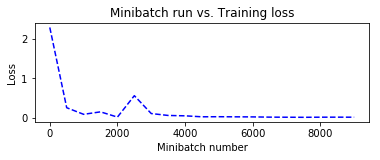

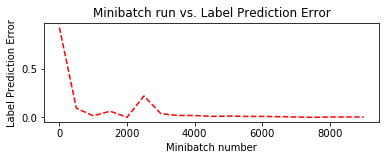

In [19]:
# Compute the moving average loss to smooth out the noise in SGD
plotdata["avgloss"] = moving_average(plotdata["loss"])
plotdata["avgerror"] = moving_average(plotdata["error"])

# Plot the training loss and the training error
import matplotlib.pyplot as plt

plt.figure(1)
plt.subplot(211)
plt.plot(plotdata["batchsize"], plotdata["avgloss"], 'b--')
plt.xlabel('Minibatch number')
plt.ylabel('Loss')
plt.title('Minibatch run vs. Training loss')

plt.show()

plt.subplot(212)
plt.plot(plotdata["batchsize"], plotdata["avgerror"], 'r--')
plt.xlabel('Minibatch number')
plt.ylabel('Label Prediction Error')
plt.title('Minibatch run vs. Label Prediction Error')
plt.show()

In [23]:
reader_test = create_reader(test_file, False, input_dim, num_output_classes)

test_input_map = {
    label  : reader_test.streams.labels,
    input  : reader_test.streams.features,
}

# Test data for trained model
test_minibatch_size = 512
num_samples = 10000
num_minibatches_to_test = num_samples // test_minibatch_size
test_result = 0.0

for i in range(num_minibatches_to_test):
    
    # We are loading test data in batches specified by test_minibatch_size
    # Each data point in the minibatch is a MNIST digit image of 784 dimensions 
    # with one pixel per dimension that we will encode / decode with the 
    # trained model.
    data = reader_test.next_minibatch(test_minibatch_size,
                                      input_map = test_input_map)

    eval_error = trainer.test_minibatch(data)
    test_result = test_result + eval_error

    
print("Average test error: {0:.2f}%".format(test_result*100 / num_minibatches_to_test))

Average test error: 1.81%


In [24]:
out = C.softmax(z)

In [26]:
reader_eval = create_reader(test_file, False, input_dim, num_output_classes)

eval_minibatch_size = 25
eval_input_map = {input : reader_eval.streams.features}

data = reader_test.next_minibatch(eval_minibatch_size, input_map = test_input_map)

img_label = data[label].asarray()
img_data = data[input].asarray()
predicted_label_prop = [out.eval(img_data[i]) for i in range(len(img_data))]

In [29]:
pred = [np.argmax(predicted_label_prop[i]) for i in range(len(predicted_label_prop))]
gtlabel = [np.argmax(img_label[i]) for i in range(len(img_label))]

In [30]:
print("Label    :", gtlabel[:25])
print("Predicted:", pred)

Label    : [4, 5, 6, 7, 8, 9, 7, 4, 6, 1, 4, 0, 9, 9, 3, 7, 8, 4, 7, 5, 8, 5, 3, 2, 2]
Predicted: [4, 6, 6, 7, 8, 9, 7, 4, 6, 1, 4, 0, 9, 9, 3, 7, 8, 6, 7, 5, 8, 6, 3, 2, 2]


Image Label:  6


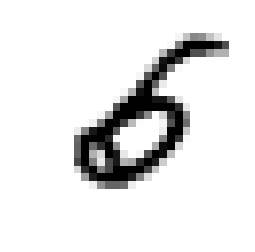

In [36]:

# Plot a random image
sample_number = 1
plt.imshow(img_data[sample_number].reshape(28,28), cmap="gray_r")
plt.axis('off')

img_gt, img_pred = gtlabel[sample_number], pred[sample_number]
print("Image Label: ", img_pred)